In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../astro_tools')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import ImageGrid
from reproject import reproject_interp
from astropy import units as u
from matplotlib.lines import Line2D
from spectral_cube import SpectralCube
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import take_slice
import routine
from astropy.wcs.utils import pixel_to_skycoord
import pvextractor
import cmasher as cmr

# set up the plot
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

Afont = {
        'family' : 'courier new',
        'color':  'black',
        'size': 18,
        }

Afontw = {
        'family' : 'courier new',
        'color':  'white',
        'size': 22,
        }

In [2]:
def guesses_CO_SW(position, params):

    if position == 0.0:
        amp1 = 3
        vel1 = 250
        sig1 = 20
        amp2 = 1
        vel2 = 400
        sig2 = 20
        guess_list = [amp1,vel1,sig1,amp2,vel2,sig2]
        limits = None
        limited = [(False, False), (False, False), (False, False), 
                   (False, False), (False, False), (False, False)]

        
#     elif position < 2.7:
#         guess_list = params
#         limits = [(0,0), (100,200), (0,0), (0,0), (250,400), (0,0)]
#         limited = [(False, False), (True, True), (False, False), 
#                    (False, False), (True, True), (False, False)]
        
    else:
        guess_list = params
        limits = None
        limited = [(False, False), (False, False), (False, False), 
                   (False, False), (False, False), (False, False)]
    
    return guess_list, limits, limited


def guesses_CO_SW3(position, params):

    if position == 0.0:
        amp1 = 3
        vel1 = 150
        sig1 = 20
        amp2 = 1
        vel2 = 350
        sig2 = 20
        guess_list = [amp1,vel1,sig1,amp2,vel2,sig2]
        limits = [(0,0), (0,200), (0,0), (0,0), (0,0), (0,0)]
        limited = [(False, False), (False, True), (False, False), 
                   (False, False), (False, False), (False, False)]

        
    else:
        guess_list = params
        limits = [(0,0), (0,200), (0,0), (0,0), (0,0), (0,0)]
        limited = [(False, False), (False, True), (False, False), 
                   (False, False), (False, False), (False, False)]
        
    return guess_list, limits, limited


def guesses_NII_SW(position, params):

    if position == 0.0:
        amp1 = 300
        vel1 = 150
        sig1 = 20
        amp2 = 300
        vel2 = 350
        sig2 = 20
        guess_list = [amp1,vel1,sig1,amp2,vel2,sig2]
        limits = [(0,0), (0,200), (0,0), (0,0), (0,0), (0,0)]
        limited = [(False, False), (False, True), (False, False), 
                   (False, False), (False, False), (False, False)]

        
    else:
        guess_list = params
        limits = [(0,0), (0,200), (0,0), (0,0), (0,0), (0,0)]
        limited = [(False, False), (False, True), (False, False), 
                   (False, False), (False, False), (False, False)]
        
    return guess_list, limits, limited


Extract the slices.

In [3]:
Vsys_center = 243.
Vsys_sw = 280.

# define the slice!
length1 = 8
length2 = 5
length3 = 5
pa = 333+180  # measuring N-S
width = 10*0.3

# ============================================================================================================
# ============================================================================================================
COfilename = '../ngc253/data/CO21_briggs_03aug2017_feather_SD1_newTP_flg_agr_vel2_09jul2018_dropsto.fits'
velocity_convention = 'radio'
restfreq = 230.538 * u.GHz
ContUpper = 450
ContLower = 100

x1_CO_SW = 230
y1_CO_SW = 177

x2_CO_SW = 221
y2_CO_SW = 160

x3_CO_SW = 207
y3_CO_SW = 133

# extract the slice and the spectra along the slice
COslice1, path1CO, spectra_list1, COspatial_axis_arcsec1, velocity_axis = take_slice.slice_extractor(COfilename,
               x1_CO_SW, y1_CO_SW, length1, pa, width, velocity_convention, restfreq)

COslice2, path2CO, spectra_list2, COspatial_axis_arcsec2, velocity_axis = take_slice.slice_extractor(COfilename,
               x2_CO_SW, y2_CO_SW, length2, pa, width, velocity_convention, restfreq)

# extract the slice and the spectra along the slice
COslice3, path3CO, spectra_list3, COspatial_axis_arcsec3, velocity_axis = take_slice.slice_extractor(COfilename,
               x3_CO_SW, y3_CO_SW, length3, pa, width, velocity_convention, restfreq)


# ============================================================================================================
# ============================================================================================================
NIIfilename = '../ngc253/data/ADP.2018-11-22T21_29_46.157.fits'
fits2_file = '../ngc253/June21/fits2_total/fits2_reordered.txt'
ERRfits2_file = '../ngc253/June21/fits2_total/fits2_err_reordered.txt'
NII = fits.open(NIIfilename)[1]
z, y, x = NII.data.shape

NII_vels_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue.fits')
NII_vels_blue_3D = np.empty((1,NII_vels_blue[0].data.shape[0],NII_vels_blue[0].data.shape[1]))
NII_vels_blue_3D[:,:,:] = NII_vels_blue[0].data
NII_vels_cube = SpectralCube(NII_vels_blue_3D, wcs=wcs.WCS(NII))

NII_fwhm_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_fwhm_outflow_blue.fits')
NII_fwhm_blue_3D = np.empty((1,NII_fwhm_blue[0].data.shape[0],NII_fwhm_blue[0].data.shape[1]))
NII_fwhm_blue_3D[:,:,:] = NII_fwhm_blue[0].data
NII_fwhm_cube = SpectralCube(NII_fwhm_blue_3D, wcs=wcs.WCS(NII))
# ------------------------------------------------------------------------------------------------------------

# extract the first slice
x1_NII_SW = 315
y1_NII_SW = 277
coord1 = pixel_to_skycoord(x1_NII_SW, y1_NII_SW, wcs=wcs.WCS(NII))
path1NII = pvextractor.PathFromCenter(center=coord1,
                    length=length1 * u.arcsec,
                    angle=pa * u.deg,
                    width=width*u.arcsec)  # 10 pixels wide    
NIIslice1_vels = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path1NII)
NIIslice1_fwhm = pvextractor.extract_pv_slice(cube=NII_fwhm_cube, path=path1NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list1 = [float(NIIslice1_vels.data[:,i]) for i in range(NIIslice1_vels.shape[1])]
NII_fwhm_list1 = [float(NIIslice1_fwhm.data[:,i]) for i in range(NIIslice1_fwhm.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg1 = wcs.WCS(NIIslice1_vels.header).array_index_to_world_values(np.zeros(NIIslice1_vels.shape[1]), np.arange(NIIslice1_vels.shape[1]))
NIIspatial_axis_arcsec1 = (NIIspatial_axis_deg1[0] * u.deg).to(u.arcsec).to_value()

# -------------------------------------------------------------------------------------------------------------

# extract second the slice
x2_NII_SW = 301
y2_NII_SW = 250
coord2 = pixel_to_skycoord(x2_NII_SW, y2_NII_SW, wcs=wcs.WCS(NII))
path2NII = pvextractor.PathFromCenter(center=coord2,
                    length=length2 * u.arcsec,
                    angle=pa * u.deg,
                    width=width*u.arcsec)  # 10 pixels wide    
NIIslice2_vels = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path2NII)
NIIslice2_fwhm = pvextractor.extract_pv_slice(cube=NII_fwhm_cube, path=path2NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list2 = [float(NIIslice2_vels.data[:,i]) for i in range(NIIslice2_vels.shape[1])]
NII_fwhm_list2 = [float(NIIslice2_fwhm.data[:,i]) for i in range(NIIslice2_fwhm.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg2 = wcs.WCS(NIIslice2_vels.header).array_index_to_world_values(np.zeros(NIIslice2_vels.shape[1]), np.arange(NIIslice2_vels.shape[1]))
NIIspatial_axis_arcsec2 = (NIIspatial_axis_deg2[0] * u.deg).to(u.arcsec).to_value()

# -------------------------------------------------------------------------------------------------------------

# extract the third slice
x3_NII_SW = 280
y3_NII_SW = 210
coord3 = pixel_to_skycoord(x3_NII_SW, y3_NII_SW, wcs=wcs.WCS(NII))
path3NII = pvextractor.PathFromCenter(center=coord3,
                    length=length3 * u.arcsec,
                    angle=pa * u.deg,
                    width=width*u.arcsec)  # 10 pixels wide    
NIIslice3_vels = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path3NII)
NIIslice3_fwhm = pvextractor.extract_pv_slice(cube=NII_fwhm_cube, path=path3NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list3 = [float(NIIslice3_vels.data[:,i]) for i in range(NIIslice3_vels.shape[1])]
NII_fwhm_list3 = [float(NIIslice3_fwhm.data[:,i]) for i in range(NIIslice3_fwhm.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg3 = wcs.WCS(NIIslice3_vels.header).array_index_to_world_values(np.zeros(NIIslice3_vels.shape[1]), np.arange(NIIslice3_vels.shape[1]))
NIIspatial_axis_arcsec3 = (NIIspatial_axis_deg3[0] * u.deg).to(u.arcsec).to_value()

# ------------------------------------------------------------------------------------------------------------
# ERRORS

# ERRNII_vels_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue_ERR.fits')
# ERRNII_vels_blue_3D = np.empty((1,ERRNII_vels_blue[0].data.shape[0],ERRNII_vels_blue[0].data.shape[1]))
# ERRNII_vels_blue_3D[:,:,:] = ERRNII_vels_blue[0].data
# ERRNII_vels_cube = SpectralCube(ERRNII_vels_blue_3D, wcs=wcs.WCS(NII))
# # ------------------------------------------------------------------------------------------------------------
# ERRmyslice1 = pvextractor.extract_pv_slice(cube=ERRNII_vels_cube, path=path1NII)
# ERRNII_vels_list1 = [float(ERRmyslice1.data[:,i]) for i in range(ERRmyslice1.shape[1])]

# ERRmyslice2 = pvextractor.extract_pv_slice(cube=ERRNII_vels_cube, path=path2NII)
# ERRNII_vels_list2 = [float(ERRmyslice2.data[:,i]) for i in range(ERRmyslice2.shape[1])]

# ERRmyslice3 = pvextractor.extract_pv_slice(cube=ERRNII_vels_cube, path=path3NII)
# ERRNII_vels_list3 = [float(ERRmyslice3.data[:,i]) for i in range(ERRmyslice3.shape[1])]

Plot the slices.

Difference between Slice1 and Slice2: 0.41723751769896467 arcsec
Difference between Slice2 and Slice3: 4.035485566612918 arcsec


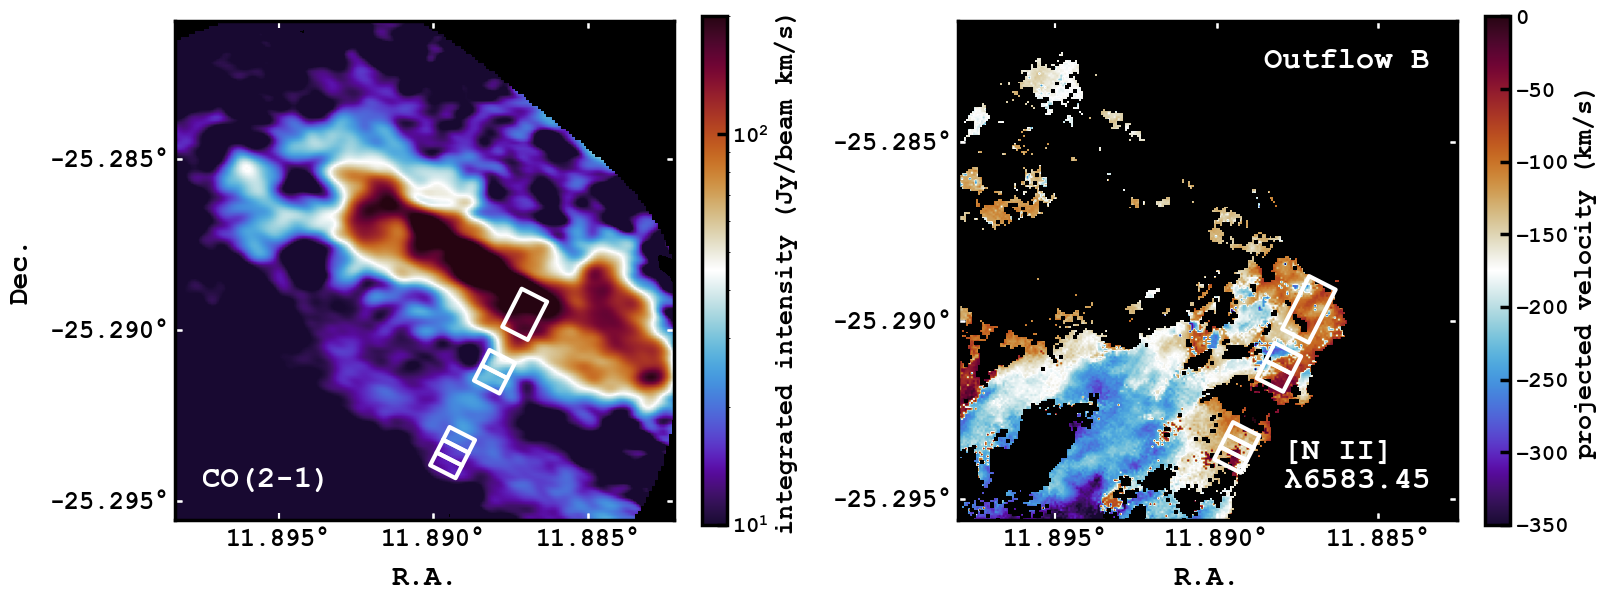

In [4]:
cmap_CO = cmr.fusion_r
cmap_NII = cmr.fusion_r

# ============================================================================================================
# ============================================================================================================
CO21_cube = SpectralCube.read(COfilename)
CO21 = CO21_cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=restfreq)  
CO21_mom0 = CO21.moment(order=0).to_value()  # moment 0
# CO21_mom1 = CO21.moment(order=1).to_value()
CO21w = CO21[0,:,:].wcs

plt.figure(figsize=(15,15))
ax = plt.subplot(1, 2, 1, projection=CO21w)
# im = ax.imshow(CO21_mom0 / 1000, origin='lower', vmin=10000, vmax=500000, cmap=cmap_CO, norm='log')
im = ax.imshow(CO21_mom0, origin='lower', vmin=10, vmax=200, cmap=cmap_CO, norm='log')
ax.set_title('', fontsize=18)
ax.coords[0].set_major_formatter('d.ddd')
ax.coords[1].set_major_formatter('d.ddd')
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax.set_xlabel('R.A.', fontsize=20)
ax.set_ylabel('Dec.', fontsize=20)
ax.set_xlim(110,285)
ax.set_ylim(110,285)

path1CO.show_on_axis(ax, spacing=15, edgecolor='white', linestyle='-', linewidth=3)
path2CO.show_on_axis(ax, spacing=6, edgecolor='white', linestyle='-', linewidth=3)
path3CO.show_on_axis(ax, spacing=5, edgecolor='white', linestyle='-', linewidth=3)

bar = plt.colorbar(im, fraction=0.046)
bar.set_label('integrated intensity (Jy/beam km/s)', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

at = AnchoredText('CO(2-1)', prop=Afontw, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

ax.set_facecolor('black')


# ============================================================================================================
# ============================================================================================================

ax = plt.subplot(1, 2, 2, projection=wcs.WCS(NII, naxis=2))
im = ax.imshow(NII_vels_blue_3D[0,:,:], origin='lower', vmin=-350, vmax=0, cmap=cmap_NII)
ax.set_title('', fontsize=18)
ax.coords[0].set_major_formatter('d.ddd')
ax.coords[1].set_major_formatter('d.ddd')
ax.coords[1].set_auto_axislabel(False)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax.set_xlabel('R.A.', fontsize=20)
ax.set_xlim(140, 140+252)
ax.set_ylim(175, 175+252)

path1NII.show_on_axis(ax, spacing=30, edgecolor='white', linestyle='-', linewidth=3)
path2NII.show_on_axis(ax, spacing=10, edgecolor='white', linestyle='-', linewidth=3)
path3NII.show_on_axis(ax, spacing=7, edgecolor='white', linestyle='-', linewidth=3)

bar = plt.colorbar(im, fraction=0.046)
bar.set_label('projected velocity (km/s)', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

at = AnchoredText('[N II]\n$\lambda 6583.45$', prop=Afontw, frameon=False, loc='lower right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

at = AnchoredText('Outflow B', prop=Afontw, frameon=False, loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
ax.set_facecolor('black')


# ============================================================================================================
# ============================================================================================================
    
d12 = np.abs((coord2.separation(coord1).arcsec - (length1/2 + length2/2)))
print('Difference between Slice1 and Slice2:', d12, 'arcsec')

d23 = np.abs((coord3.separation(coord2).arcsec - (length2/2 + length3/2)))
print('Difference between Slice2 and Slice3:', d23, 'arcsec')   

plt.subplots_adjust(wspace=12, hspace=0)
plt.tight_layout()
plt.savefig('../ngc253/visuals/se_co_outb.png', bbox_inches='tight', dpi=200)
plt.show()

Fit CO along each slice.

In [5]:
# extract the slice and the spectra along the slice
savepath1 = '../ngc253/June21/CO/SW/Sept19/slice1'
COslice1, path1CO, spectra_list1, COspatial_axis_arcsec1, velocity_axis = take_slice.slice_extractor(COfilename,
               x1_CO_SW, y1_CO_SW, length1, pa, width, velocity_convention, restfreq)

# generate the text files we want
take_slice.generate_text_files(savepath1)

# run the gaussian fitter to extract velocities
take_slice.velocity_extractor(savepath1, guesses_CO_SW, spectra_list1, COspatial_axis_arcsec1, 
                   velocity_axis, ContUpper, ContLower)

# grab velocities and errors from text files
CO_amps1, CO_amp_errs1, CO_vels1, CO_vel_errs1, CO_sigs1, CO_sig_errs1 = take_slice.extract_blue_velocities(savepath1)

# ============================================================================================================
# ============================================================================================================
# do again for the second slice
savepath2 = '../ngc253/June21/CO/SW/Sept19/slice2'
COslice2, path2CO, spectra_list2, COspatial_axis_arcsec2, velocity_axis = take_slice.slice_extractor(COfilename,
               x2_CO_SW, y2_CO_SW, length2, pa, width, velocity_convention, restfreq)
take_slice.generate_text_files(savepath2)
take_slice.velocity_extractor(savepath2, guesses_CO_SW, spectra_list2, COspatial_axis_arcsec2, 
                   velocity_axis, ContUpper, ContLower)
CO_amps2, CO_amp_errs2, CO_vels2, CO_vel_errs2, CO_sigs2, CO_sig_errs2 = take_slice.extract_blue_velocities(savepath2)

# ============================================================================================================
# ============================================================================================================
# do again for the third slice
savepath3 = '../ngc253/June21/CO/SW/Sept19/slice3'
COslice3, path2CO, spectra_list3, COspatial_axis_arcsec3, velocity_axis = take_slice.slice_extractor(COfilename,
               x3_CO_SW, y3_CO_SW, length3, pa, width, velocity_convention, restfreq)
take_slice.generate_text_files(savepath3)
take_slice.velocity_extractor(savepath3, guesses_CO_SW3, spectra_list3, COspatial_axis_arcsec3, 
                   velocity_axis, ContUpper, ContLower)
CO_amps3, CO_amp_errs3, CO_vels3, CO_vel_errs3, CO_sigs3, CO_sig_errs3 = take_slice.extract_blue_velocities(savepath3)


Pixel 26/26
Pixel 16/16


### Plot & analyze CO vs. NII velocities!

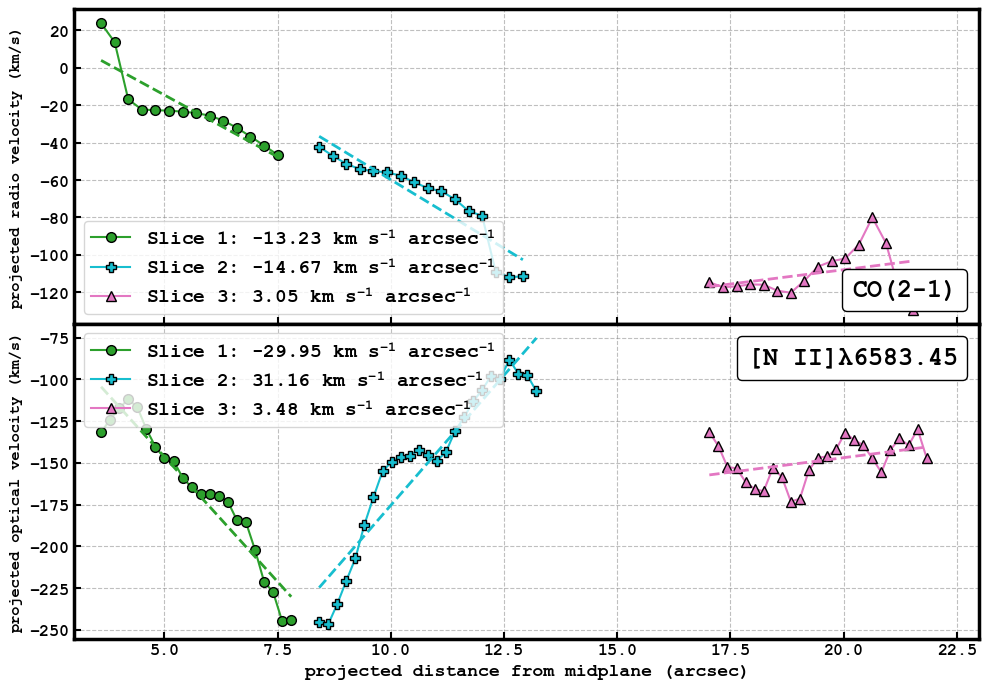

In [6]:
plt.figure(figsize=(10,7))

# ============================================================================================================
# ============================================================================================================
ax = plt.subplot(2,1,1)
inds = np.argwhere(COspatial_axis_arcsec1 > 3.5).flatten()  # outflow is starting around here
CO_sw_vels_Vsys1 = np.array(CO_vels1)[inds] - Vsys_sw
#CO_sw_errs_Vsys1 = np.array(CO_vel_errs1)[inds] #- Vsys_sw)
COspatial_axis_arcsec1_fixed = COspatial_axis_arcsec1[inds]
m1,b1 = np.polyfit(COspatial_axis_arcsec1_fixed, CO_sw_vels_Vsys1, 1) # best fit line

# plt.fill_between(COspatial_axis_arcsec1_fixed, CO_sw_vels_Vsys1 - CO_sw_errs_Vsys1, 
#                  CO_sw_vels_Vsys1+CO_sw_errs_Vsys1, color='tab:green', alpha=0.5)
plt.plot(COspatial_axis_arcsec1_fixed, CO_sw_vels_Vsys1, 'o-', markeredgecolor='black', ms=7, label='Slice 1: %s km s$^{-1}$ arcsec$^{-1}$' % round(m1,2), color='tab:green')
plt.plot(COspatial_axis_arcsec1_fixed, m1*COspatial_axis_arcsec1_fixed+b1, color='tab:green', ls='--', lw=2)

# ----------------------------------------------------------------------------------------------------------
ax = plt.subplot(2,1,1)

CO_sw_vels_Vsys2 = np.array(CO_vels2) - Vsys_sw
#CO_sw_errs_Vsys2 = np.array(CO_vel_errs2) #- Vsys_sw)
COspatial_axis_arcsec2_fixed = COspatial_axis_arcsec2 + length1 + d12
m2,b2 = np.polyfit(COspatial_axis_arcsec2_fixed, CO_sw_vels_Vsys2, 1) # best fit line

# plt.fill_between(COspatial_axis_arcsec2_fixed, CO_sw_vels_Vsys2 - CO_sw_errs_Vsys2, 
#                  CO_sw_vels_Vsys2+CO_sw_errs_Vsys2, color='tab:cyan', alpha=0.5)
plt.plot(COspatial_axis_arcsec2_fixed, CO_sw_vels_Vsys2, 'P-', markeredgecolor='black', ms=7, label='Slice 2: %s km s$^{-1}$ arcsec$^{-1}$' % round(m2,2), color='tab:cyan')
plt.plot(COspatial_axis_arcsec2_fixed, m2*COspatial_axis_arcsec2_fixed+b2, color='tab:cyan', ls='--', lw=2)

# ----------------------------------------------------------------------------------------------------------
ax = plt.subplot(2,1,1)
CO_sw_vels_Vsys3 = np.array(CO_vels3) - Vsys_sw
# CO_sw_errs_Vsys3 = np.array(CO_vel_errs3) #- Vsys_sw)

COspatial_axis_arcsec3_fixed = COspatial_axis_arcsec3 + length1 + length2 + d23
m3,b3 = np.polyfit(COspatial_axis_arcsec3_fixed, CO_sw_vels_Vsys3, 1) # best fit line

# plt.fill_between(COspatial_axis_arcsec3_fixed, CO_sw_vels_Vsys3 - CO_sw_errs_Vsys3, 
#                  CO_sw_vels_Vsys3+CO_sw_errs_Vsys3, color='tab:pink', alpha=0.5)
plt.plot(COspatial_axis_arcsec3_fixed, CO_sw_vels_Vsys3, '^-', markeredgecolor='black', ms=7, label='Slice 3: %s km s$^{-1}$ arcsec$^{-1}$' % round(m3,2), color='tab:pink')
plt.plot(COspatial_axis_arcsec3_fixed, m3*COspatial_axis_arcsec3_fixed+b3, color='tab:pink', ls='--', lw=2)

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=14, loc='lower left')
plt.ylabel('projected radio velocity (km/s)', fontsize=11)
# plt.ylim(-250,90)
plt.xlim(3,23)
plt.grid(ls='--',color='gray', alpha=0.5)
at = AnchoredText('CO(2-1)', prop=Afont, frameon=True, loc='lower right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

# ============================================================================================================
# ============================================================================================================
ax = plt.subplot(2,1,2)
inds = np.argwhere(NIIspatial_axis_arcsec1 > 3.5).flatten()
NII_sw_vels_Vsys1 = np.array(NII_vels_list1)[inds] + Vsys_center - Vsys_sw  # fix systemic vel
# NII_sw_errs_Vsys1 = np.array(ERRNII_vels_list1)[inds] #- Vsys_sw)
NIIspatial_axis_arcsec1_fixed = NIIspatial_axis_arcsec1[inds]
m1,b1 = np.polyfit(NIIspatial_axis_arcsec1_fixed, NII_sw_vels_Vsys1, 1) # best fit line

# plt.fill_between(NIIspatial_axis_arcsec1_fixed, NII_sw_vels_Vsys1 - NII_sw_errs_Vsys1, 
#                  NII_sw_vels_Vsys1+NII_sw_errs_Vsys1, color='tab:green', alpha=0.5)
plt.plot(NIIspatial_axis_arcsec1_fixed, NII_sw_vels_Vsys1, 'o-', markeredgecolor='black', ms=7, label='Slice 1: %s km s$^{-1}$ arcsec$^{-1}$' % round(m1,2), color='tab:green')
plt.plot(NIIspatial_axis_arcsec1_fixed, m1*NIIspatial_axis_arcsec1_fixed+b1, color='tab:green', ls='--', lw=2)

# ----------------------------------------------------------------------------------------------------------
ax = plt.subplot(2,1,2)
NII_sw_vels_Vsys2 = np.array(NII_vels_list2) + Vsys_center - Vsys_sw  # fix systemic vel
# NII_sw_errs_Vsys2 = np.array(ERRNII_vels_list2) #- Vsys_sw)

NIIspatial_axis_arcsec2_fixed = NIIspatial_axis_arcsec2 + length1 + d12
m2,b2 = np.polyfit(NIIspatial_axis_arcsec2_fixed, NII_sw_vels_Vsys2, 1) # best fit line

# plt.fill_between(NIIspatial_axis_arcsec2_fixed, NII_sw_vels_Vsys2 - NII_sw_errs_Vsys2, 
#                  NII_sw_vels_Vsys2+NII_sw_errs_Vsys2, color='tab:cyan', alpha=0.5)
plt.plot(NIIspatial_axis_arcsec2_fixed, NII_sw_vels_Vsys2, 'P-', markeredgecolor='black', ms=7, label='Slice 2: %s km s$^{-1}$ arcsec$^{-1}$' % round(m2,2),color='tab:cyan')
plt.plot(NIIspatial_axis_arcsec2_fixed, m2*NIIspatial_axis_arcsec2_fixed+b2, color='tab:cyan', ls='--', lw=2)

# ----------------------------------------------------------------------------------------------------------
ax = plt.subplot(2,1,2)
NII_sw_vels_Vsys3 = np.array(NII_vels_list3) + Vsys_center - Vsys_sw  # fix systemic vel
# NII_sw_errs_Vsys3 = np.array(ERRNII_vels_list3) #- Vsys_sw)

NIIspatial_axis_arcsec3_fixed = NIIspatial_axis_arcsec3 + length1 + length2 + d23
m3,b3 = np.polyfit(NIIspatial_axis_arcsec3_fixed, NII_sw_vels_Vsys3, 1) # best fit line

# plt.fill_between(NIIspatial_axis_arcsec3_fixed, NII_sw_vels_Vsys3 - NII_sw_errs_Vsys3, 
#                  NII_sw_vels_Vsys3+NII_sw_errs_Vsys3, color='tab:pink', alpha=0.5)
plt.plot(NIIspatial_axis_arcsec3_fixed, NII_sw_vels_Vsys3, '^-', markeredgecolor='black', ms=7, label='Slice 3: %s km s$^{-1}$ arcsec$^{-1}$' % round(m3,2), color='tab:pink')
plt.plot(NIIspatial_axis_arcsec3_fixed, m3*NIIspatial_axis_arcsec3_fixed+b3, color='tab:pink', ls='--', lw=2)


ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=14, loc='upper left')
plt.ylabel('projected optical velocity (km/s)', fontsize=11)
plt.xlabel('projected distance from midplane (arcsec)', fontsize=13)
# plt.ylim(-250,90)
plt.xlim(3,23)
plt.grid(ls='--',color='gray', alpha=0.5)

at = AnchoredText('[N II]$\lambda 6583.45$', prop=Afont, frameon=True, loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

plt.tight_layout()
plt.subplots_adjust(hspace=-0.001)
plt.show()

Now take the center velocity and subtract 1 standard deviation. This will have us track the blueshifted part of the outflow component.

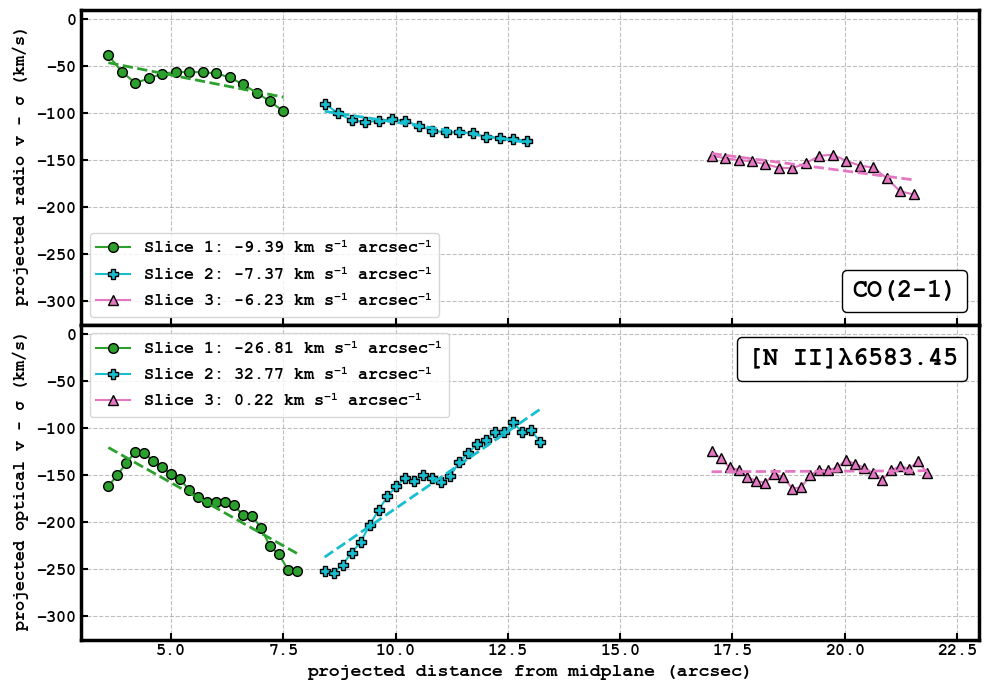

In [7]:
plt.figure(figsize=(10,7))

# ============================================================================================================
# ============================================================================================================
ax = plt.subplot(2,1,1)
inds = np.argwhere(COspatial_axis_arcsec1 > 3.5).flatten()  # outflow is starting around here
CO_vels_Vsys1 = np.array(CO_vels1)[inds] - Vsys_sw
CO_sigs_Vsys1 = np.array(CO_sigs1)[inds]
CO_vels_sigs_Vsys1 = CO_vels_Vsys1 - CO_sigs_Vsys1

# CO_vels_errs1 = np.array(CO_vel_errs1)[inds] #- Vsys_sw.)
# CO_sigs_errs1 = np.array(CO_sig_errs1)[inds]
# CO_vels_sigs_errs1 = CO_vels_errs1 + CO_sigs_errs1

COspatial_axis_arcsec1_fixed = COspatial_axis_arcsec1[inds]
m1,b1 = np.polyfit(COspatial_axis_arcsec1_fixed, CO_vels_sigs_Vsys1, 1) # best fit line

# plt.fill_between(COspatial_axis_arcsec1_fixed, CO_vels_sigs_Vsys1 - CO_vels_sigs_errs1, 
#                  CO_vels_sigs_Vsys1+CO_vels_sigs_errs1, color='tab:green', alpha=0.5)
plt.plot(COspatial_axis_arcsec1_fixed, CO_vels_sigs_Vsys1, 'o-', markeredgecolor='black', ms=7, 
         label='Slice 1: %s km s$^{-1}$ arcsec$^{-1}$' % round(m1,2), color='tab:green')
plt.plot(COspatial_axis_arcsec1_fixed, m1*COspatial_axis_arcsec1_fixed+b1, color='tab:green', ls='--', lw=2)

# ----------------------------------------------------------------------------------------------------------
ax = plt.subplot(2,1,1)

CO_vels_Vsys2 = np.array(CO_vels2) - Vsys_sw
CO_sigs_Vsys2 = np.array(CO_sigs2)
CO_vels_sigs_Vsys2 = CO_vels_Vsys2 - CO_sigs_Vsys2

# CO_vels_errs2 = np.array(CO_vel_errs2) #- Vsys_sw.)
# CO_sigs_errs2 = np.array(CO_sig_errs2)
# CO_vels_sigs_errs2 = CO_vels_errs2 + CO_sigs_errs2

COspatial_axis_arcsec2_fixed = COspatial_axis_arcsec2 + length1 + d12
m2,b2 = np.polyfit(COspatial_axis_arcsec2_fixed, CO_vels_sigs_Vsys2, 1) # best fit line

# plt.fill_between(COspatial_axis_arcsec2_fixed, CO_vels_sigs_Vsys2 - CO_vels_sigs_errs2, 
#                  CO_vels_sigs_Vsys2+CO_vels_sigs_errs2, color='tab:cyan', alpha=0.5)
plt.plot(COspatial_axis_arcsec2_fixed, CO_vels_sigs_Vsys2, 'P-', markeredgecolor='black', ms=7, 
         label='Slice 2: %s km s$^{-1}$ arcsec$^{-1}$' % round(m2,2), color='tab:cyan')
plt.plot(COspatial_axis_arcsec2_fixed, m2*COspatial_axis_arcsec2_fixed+b2, color='tab:cyan', ls='--', lw=2)

# ----------------------------------------------------------------------------------------------------------
ax = plt.subplot(2,1,1)

CO_vels_Vsys3 = np.array(CO_vels3) - Vsys_sw
CO_sigs_Vsys3 = np.array(CO_sigs3)
CO_vels_sigs_Vsys3 = CO_vels_Vsys3 - CO_sigs_Vsys3

# CO_vels_errs3 = np.array(CO_vel_errs3) #- Vsys_sw)
# CO_sigs_errs3 = np.array(CO_sig_errs3)
# CO_vels_sigs_errs3 = CO_vels_errs3 + CO_sigs_errs3

COspatial_axis_arcsec3_fixed = COspatial_axis_arcsec3 + length1 + length2 + d23
m3,b3 = np.polyfit(COspatial_axis_arcsec3_fixed, CO_vels_sigs_Vsys3, 1) # best fit line

# plt.fill_between(COspatial_axis_arcsec3_fixed, CO_vels_sigs_Vsys3 - CO_vels_sigs_errs3, 
#                  CO_vels_sigs_Vsys3+CO_vels_sigs_errs3, color='tab:pink', alpha=0.5)
plt.plot(COspatial_axis_arcsec3_fixed, CO_vels_sigs_Vsys3, '^-', markeredgecolor='black', ms=7, 
         label='Slice 3: %s km s$^{-1}$ arcsec$^{-1}$' % round(m3,2), color='tab:pink')
plt.plot(COspatial_axis_arcsec3_fixed, m3*COspatial_axis_arcsec3_fixed+b3, color='tab:pink', ls='--', lw=2)

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=12, loc='lower left')
plt.ylabel('projected radio v - $\sigma$ (km/s)', fontsize=12)
plt.ylim(-325,10)
plt.xlim(3,23)
plt.grid(ls='--',color='gray', alpha=0.5)

at = AnchoredText('CO(2-1)', prop=Afont, frameon=True, loc='lower right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

# ============================================================================================================
# ============================================================================================================
ax = plt.subplot(2,1,2)
inds = np.argwhere(NIIspatial_axis_arcsec1 > 3.5).flatten()  # only needed for the first slice
NII_sw_vels_Vsys1 = np.array(NII_vels_list1)[inds]
NII_sw_sigs_Vsys1 = np.array(NII_fwhm_list1)[inds] / 2.355
NII_sw_vels_sigs_Vsys1 = NII_sw_vels_Vsys1 - NII_sw_sigs_Vsys1
# NII_sw_errs_Vsys1 = np.array(ERRNII_vels_list1)[inds] #- Vsys_sw.)
NIIspatial_axis_arcsec1_fixed = NIIspatial_axis_arcsec1[inds]
m1,b1 = np.polyfit(NIIspatial_axis_arcsec1_fixed, NII_sw_vels_sigs_Vsys1, 1) # best fit line

# plt.fill_between(NIIspatial_axis_arcsec1_fixed, NII_sw_vels_Vsys1 - NII_sw_errs_Vsys1, 
#                  NII_sw_vels_Vsys1+NII_sw_errs_Vsys1, color='tab:green', alpha=0.5)
plt.plot(NIIspatial_axis_arcsec1_fixed, NII_sw_vels_sigs_Vsys1, 'o-', markeredgecolor='black', ms=7, 
         label='Slice 1: %s km s$^{-1}$ arcsec$^{-1}$' % round(m1,2), color='tab:green')
plt.plot(NIIspatial_axis_arcsec1_fixed, m1*NIIspatial_axis_arcsec1_fixed+b1, color='tab:green', ls='--', lw=2)

# ----------------------------------------------------------------------------------------------------------
ax = plt.subplot(2,1,2)
NII_sw_vels_Vsys2 = np.array(NII_vels_list2)
NII_sw_sigs_Vsys2 = np.array(NII_fwhm_list2) / 2.355
NII_sw_vels_sigs_Vsys2 = NII_sw_vels_Vsys2 - NII_sw_sigs_Vsys2
# NII_sw_errs_Vsys2 = np.array(ERRNII_vels_list2) #- Vsys_sw)

NIIspatial_axis_arcsec2_fixed = NIIspatial_axis_arcsec2 + length1 + d12
m2,b2 = np.polyfit(NIIspatial_axis_arcsec2_fixed, NII_sw_vels_sigs_Vsys2, 1) # best fit line

# plt.fill_between(NIIspatial_axis_arcsec2_fixed, NII_sw_vels_Vsys2 - NII_sw_errs_Vsys2, 
#                  NII_sw_vels_Vsys2+NII_sw_errs_Vsys2, color='tab:cyan', alpha=0.5)
plt.plot(NIIspatial_axis_arcsec2_fixed, NII_sw_vels_sigs_Vsys2, 'P-', markeredgecolor='black', ms=7, 
         label='Slice 2: %s km s$^{-1}$ arcsec$^{-1}$' % round(m2,2),color='tab:cyan')
plt.plot(NIIspatial_axis_arcsec2_fixed, m2*NIIspatial_axis_arcsec2_fixed+b2, color='tab:cyan', ls='--', lw=2)

# ----------------------------------------------------------------------------------------------------------
ax = plt.subplot(2,1,2)
NII_sw_vels_Vsys3 = np.array(NII_vels_list3)
NII_sw_sigs_Vsys3 = np.array(NII_fwhm_list3) / 2.355
NII_sw_vels_sigs_Vsys3 = NII_sw_vels_Vsys3 - NII_sw_sigs_Vsys3
# NII_sw_errs_Vsys3 = np.array(ERRNII_vels_list3) #- Vsys_sw)

NIIspatial_axis_arcsec3_fixed = NIIspatial_axis_arcsec3 + length1 + length2 + d23
m3,b3 = np.polyfit(NIIspatial_axis_arcsec3_fixed, NII_sw_vels_sigs_Vsys3, 1) # best fit line

# plt.fill_between(NIIspatial_axis_arcsec3_fixed, NII_sw_vels_Vsys3 - NII_sw_errs_Vsys3, 
#                  NII_sw_vels_Vsys3+NII_sw_errs_Vsys3, color='tab:pink', alpha=0.5)
plt.plot(NIIspatial_axis_arcsec3_fixed, NII_sw_vels_sigs_Vsys3, '^-', markeredgecolor='black', ms=7, 
         label='Slice 3: %s km s$^{-1}$ arcsec$^{-1}$' % round(m3,2), color='tab:pink')
plt.plot(NIIspatial_axis_arcsec3_fixed, m3*NIIspatial_axis_arcsec3_fixed+b3, color='tab:pink', ls='--', lw=2)


ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('projected optical v - $\sigma$ (km/s)', fontsize=12)
plt.xlabel('projected distance from midplane (arcsec)', fontsize=13)

plt.xlim(3,23)
plt.ylim(-325,10)
plt.grid(ls='--',color='gray', alpha=0.5)

at = AnchoredText('[N II]$\lambda 6583.45$', prop=Afont, frameon=True, loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

plt.tight_layout()
plt.subplots_adjust(hspace=-0.001)
plt.show()

Now let's weight the velocities of [N II] by intensity.

In [8]:
# weight the velocities by intensity
NII_vels_blue_file = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue.fits')
NII_amps_blue_file = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_amp_outflow_blue.fits')
NII_vels_blue = np.nan_to_num(NII_vels_blue_file[0].data)
NII_amps_blue = np.nan_to_num(NII_amps_blue_file[0].data)

# NII_vels_blue[np.isnan(NII_vels_blue)] = 0.
# norm = (NII_amps_blue-np.min(NII_amps_blue))/(np.max(NII_amps_blue)-np.min(NII_amps_blue))
# NII_weighted_vels = (NII_vels_blue * norm)
# NII_weighted_vels[np.isnan(NII_vels_blue_file[0].data)] = np.nan  # get the nans back baybeeeeee

# numerator to the weighted velocities; amplitude * velocity
NII_weighted_vels = NII_amps_blue * NII_vels_blue
hdul = fits.PrimaryHDU(data=NII_weighted_vels, header=NII.header)
hdul.writeto('../ngc253/data/output_maps/ngc253_muse_se_niib_weightedvel_outflow_blue.fits',  overwrite=True)

# ============================================================================================================
# ============================================================================================================

# # do the same for the errors
# NII_vels_blue_file_ERR = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue_ERR.fits')
# NII_amps_blue_file_ERR = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_amp_outflow_blue_ERR.fits')
# NII_vels_blue_ERR = np.nan_to_num(NII_vels_blue_file_ERR[0].data)
# NII_amps_blue_ERR = np.nan_to_num(NII_amps_blue_file_ERR[0].data)

# norm_ERR = (NII_amps_blue_ERR-np.min(NII_amps_blue_ERR))/(np.max(NII_amps_blue_ERR)-np.min(NII_amps_blue_ERR))
# NII_weighted_vels_ERR = (NII_vels_blue_ERR * norm_ERR)
# NII_weighted_vels_ERR[np.isnan(NII_vels_blue_file_ERR[0].data)] = np.nan

# hdul = fits.PrimaryHDU(data=NII_weighted_vels_ERR, header=NII.header)
# hdul.writeto('../ngc253/data/output_maps/ngc253_muse_se_niib_weightedvel_outflow_blue_ERR.fits',  overwrite=True)

In [9]:
# define the slice!
length1 = 8
length2 = 5
length3 = 5
pa = 333+180  # measuring N-S
width = 10*0.3

# ============================================================================================================
# ============================================================================================================
COfilename = '../ngc253/data/CO21_briggs_03aug2017_feather_SD1_newTP_flg_agr_vel2_09jul2018_dropsto.fits'
velocity_convention = 'radio'
restfreq = 230.538 * u.GHz
ContUpper = 450
ContLower = 100

x1_CO_SW = 230
y1_CO_SW = 177

x2_CO_SW = 221
y2_CO_SW = 160

x3_CO_SW = 207
y3_CO_SW = 133

# extract the slice and the spectra along the slice
COslice1, path1CO, spectra_list1, COspatial_axis_arcsec1, velocity_axis = take_slice.slice_extractor(COfilename,
               x1_CO_SW, y1_CO_SW, length1, pa, width, velocity_convention, restfreq)

COslice2, path2CO, spectra_list2, COspatial_axis_arcsec2, velocity_axis = take_slice.slice_extractor(COfilename,
               x2_CO_SW, y2_CO_SW, length2, pa, width, velocity_convention, restfreq)

# extract the slice and the spectra along the slice
COslice3, path3CO, spectra_list3, COspatial_axis_arcsec3, velocity_axis = take_slice.slice_extractor(COfilename,
               x3_CO_SW, y3_CO_SW, length3, pa, width, velocity_convention, restfreq)


# ============================================================================================================
# ============================================================================================================
NII_vels_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_weightedvel_outflow_blue.fits')
NII_vels_blue_3D = np.empty((1,NII_vels_blue[0].data.shape[0],NII_vels_blue[0].data.shape[1]))
NII_vels_blue_3D[:,:,:] = NII_vels_blue[0].data
NII_vels_cube = SpectralCube(NII_vels_blue_3D, wcs=wcs.WCS(NII))

# also extract the amplitudes
NII_amps_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_amp_outflow_blue.fits')
NII_amps_blue_3D = np.empty((1,NII_amps_blue[0].data.shape[0],NII_amps_blue[0].data.shape[1]))
NII_amps_blue_3D[:,:,:] = NII_amps_blue[0].data
NII_amps_cube = SpectralCube(NII_amps_blue_3D, wcs=wcs.WCS(NII))
# ------------------------------------------------------------------------------------------------------------

# extract the first slice
x1_NII_SW = 315
y1_NII_SW = 277
coord1 = pixel_to_skycoord(x1_NII_SW, y1_NII_SW, wcs=wcs.WCS(NII))
path1NII = pvextractor.PathFromCenter(center=coord1,
                    length=length1 * u.arcsec,
                    angle=pa * u.deg,
                    width=width*u.arcsec)  # 10 pixels wide    
NIIslice1 = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path1NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list1 = [float(NIIslice1.data[:,i]) for i in range(NIIslice1.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg1 = wcs.WCS(NIIslice1.header).array_index_to_world_values(np.zeros(NIIslice1.shape[1]), np.arange(NIIslice1.shape[1]))
NIIspatial_axis_arcsec1 = (NIIspatial_axis_deg1[0] * u.deg).to(u.arcsec).to_value()

# divide the vels*amps by sum of the amps
NIIslice1_amps = pvextractor.extract_pv_slice(cube=NII_amps_cube, path=path1NII)
NII_amps_list1 = [float(NIIslice1_amps.data[:,i]) for i in range(NIIslice1_amps.shape[1])]
NII_weighted_vels_list1 = np.array(NII_vels_list1) / np.array(NII_amps_list1)

# -------------------------------------------------------------------------------------------------------------

# extract second the slice
x2_NII_SW = 301
y2_NII_SW = 250
coord2 = pixel_to_skycoord(x2_NII_SW, y2_NII_SW, wcs=wcs.WCS(NII))
path2NII = pvextractor.PathFromCenter(center=coord2,
                    length=length2 * u.arcsec,
                    angle=pa * u.deg,
                    width=width*u.arcsec)  # 10 pixels wide    
NIIslice2 = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path2NII)


# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list2 = [float(NIIslice2.data[:,i]) for i in range(NIIslice2.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg2 = wcs.WCS(NIIslice2.header).array_index_to_world_values(np.zeros(NIIslice2.shape[1]), np.arange(NIIslice2.shape[1]))
NIIspatial_axis_arcsec2 = (NIIspatial_axis_deg2[0] * u.deg).to(u.arcsec).to_value()

# divide the vels*amps by sum of the amps
NIIslice2_amps = pvextractor.extract_pv_slice(cube=NII_amps_cube, path=path2NII)
NII_amps_list2 = [float(NIIslice2_amps.data[:,i]) for i in range(NIIslice2_amps.shape[1])]
NII_weighted_vels_list2 = np.array(NII_vels_list2) / np.array(NII_amps_list2)

# -------------------------------------------------------------------------------------------------------------

# extract the third slice
x3_NII_SW = 280
y3_NII_SW = 210
coord3 = pixel_to_skycoord(x3_NII_SW, y3_NII_SW, wcs=wcs.WCS(NII))
path3NII = pvextractor.PathFromCenter(center=coord3,
                    length=length3 * u.arcsec,
                    angle=pa * u.deg,
                    width=width*u.arcsec)  # 10 pixels wide    
NIIslice3 = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path3NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list3 = [float(NIIslice3.data[:,i]) for i in range(NIIslice3.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg3 = wcs.WCS(NIIslice3.header).array_index_to_world_values(np.zeros(NIIslice3.shape[1]), np.arange(NIIslice3.shape[1]))
NIIspatial_axis_arcsec3 = (NIIspatial_axis_deg3[0] * u.deg).to(u.arcsec).to_value()

# divide the vels*amps by sum of the amps
NIIslice3_amps = pvextractor.extract_pv_slice(cube=NII_amps_cube, path=path3NII)
NII_amps_list3 = [float(NIIslice3_amps.data[:,i]) for i in range(NIIslice3_amps.shape[1])]
NII_weighted_vels_list3 = np.array(NII_vels_list3) / np.array(NII_amps_list3)

# ------------------------------------------------------------------------------------------------------------

# ERRNII_vels_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_weightedvel_outflow_blue_ERR.fits')
# ERRNII_vels_blue_3D = np.empty((1,ERRNII_vels_blue[0].data.shape[0],ERRNII_vels_blue[0].data.shape[1]))
# ERRNII_vels_blue_3D[:,:,:] = ERRNII_vels_blue[0].data
# ERRNII_vels_cube = SpectralCube(ERRNII_vels_blue_3D, wcs=wcs.WCS(NII))
# # ------------------------------------------------------------------------------------------------------------
# ERRmyslice1 = pvextractor.extract_pv_slice(cube=ERRNII_vels_cube, path=path1NII)
# ERRNII_vels_list1 = [float(ERRmyslice1.data[:,i]) for i in range(ERRmyslice1.shape[1])]

# ERRmyslice2 = pvextractor.extract_pv_slice(cube=ERRNII_vels_cube, path=path2NII)
# ERRNII_vels_list2 = [float(ERRmyslice2.data[:,i]) for i in range(ERRmyslice2.shape[1])]

# ERRmyslice3 = pvextractor.extract_pv_slice(cube=ERRNII_vels_cube, path=path3NII)
# ERRNII_vels_list3 = [float(ERRmyslice3.data[:,i]) for i in range(ERRmyslice3.shape[1])]

In [37]:
# extracting data from Walter+17
W17_vels = np.flip(np.array([153.552, 197.295, 192.362, 175.511, 175.378, 
            188.494, 191.672, 203.794, 234.787, 250.883]) - Vsys_sw) * u.km/u.s

W17_proj_dist = np.flip(np.abs(np.array([-16.2986, -15.0230, -13.8236, -12.5058, 
                 -11.3070, -9.99857, -8.82935,-7.52083,-6.32563,-5.00587])))

In [21]:
# want to convert CO radio to optical velocities.
opt_doppler_equiv = u.doppler_optical(restfreq)  # equivalencies
rad_doppler_equiv = u.doppler_radio(restfreq)

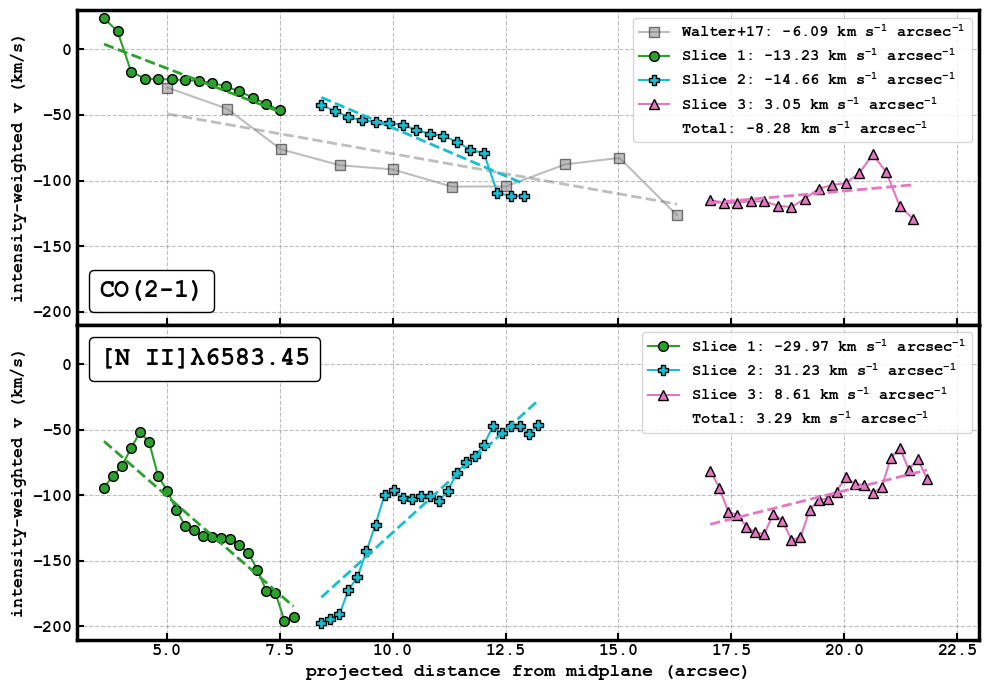

In [47]:
plt.figure(figsize=(10,7))

plt.scatter(W17_proj_dist, W17_vels)

ax = plt.subplot(2,1,1)

freq_arr = W17_vels.to(u.GHz, rad_doppler_equiv)  # get radio frequencies 
W17_opt_vels = freq_arr.to(u.km / u.s, equivalencies=opt_doppler_equiv)  # convert radio freq -> opt vel 
m_W17,b_W17 = np.polyfit(W17_proj_dist, W17_opt_vels, 1) # best fit line

plt.plot(W17_proj_dist, W17_opt_vels, 's-', markeredgecolor='black', ms=7, 
         label='Walter+17: %s km s$^{-1}$ arcsec$^{-1}$' % round(m_W17,2), alpha=0.5, color='tab:gray')
plt.plot(W17_proj_dist, m_W17*W17_proj_dist+b_W17, color='tab:gray', ls='--', lw=2, alpha=0.5)

# ============================================================================================================
# ============================================================================================================
ax = plt.subplot(2,1,1)
inds = np.argwhere(COspatial_axis_arcsec1 > 3.5).flatten()  # outflow is starting around here
CO_vels_Vsys1 = (np.array(CO_vels1)[inds] - Vsys_sw) * u.km/u.s

freq_arr = CO_vels_Vsys1.to(u.GHz, rad_doppler_equiv)  # get radio frequencies 
CO_opt_vels_Vsys1 = freq_arr.to(u.km / u.s, equivalencies=opt_doppler_equiv)  # convert radio freq -> opt vel 

# CO_vels_errs1 = np.array(CO_vel_errs1)[inds] #- Vsys_sw.)
# CO_sigs_errs1 = np.array(CO_sig_errs1)[inds]
# CO_vels_sigs_errs1 = CO_vels_errs1 + CO_sigs_errs1

COspatial_axis_arcsec1_fixed = COspatial_axis_arcsec1[inds]
m1,b1 = np.polyfit(COspatial_axis_arcsec1_fixed, CO_opt_vels_Vsys1, 1) # best fit line

# plt.fill_between(COspatial_axis_arcsec1_fixed, CO_vels_sigs_Vsys1 - CO_vels_sigs_errs1, 
#                  CO_vels_sigs_Vsys1+CO_vels_sigs_errs1, color='tab:green', alpha=0.5)
plt.plot(COspatial_axis_arcsec1_fixed, CO_opt_vels_Vsys1, 'o-', markeredgecolor='black', ms=7, 
         label='Slice 1: %s km s$^{-1}$ arcsec$^{-1}$' % round(m1,2), color='tab:green')
plt.plot(COspatial_axis_arcsec1_fixed, m1*COspatial_axis_arcsec1_fixed+b1, color='tab:green', ls='--', lw=2)

# ----------------------------------------------------------------------------------------------------------
ax = plt.subplot(2,1,1)

CO_vels_Vsys2 = (np.array(CO_vels2) - Vsys_sw) * u.km/u.s
freq_arr = CO_vels_Vsys2.to(u.GHz, rad_doppler_equiv)  # get radio frequencies 
CO_opt_vels_Vsys2 = freq_arr.to(u.km / u.s, equivalencies=opt_doppler_equiv)  # convert radio freq -> opt vel 

# CO_vels_errs2 = np.array(CO_vel_errs2) #- Vsys_sw.)
# CO_sigs_errs2 = np.array(CO_sig_errs2)
# CO_vels_sigs_errs2 = CO_vels_errs2 + CO_sigs_errs2

COspatial_axis_arcsec2_fixed = COspatial_axis_arcsec2 + length1 + d12
m2,b2 = np.polyfit(COspatial_axis_arcsec2_fixed, CO_opt_vels_Vsys2, 1) # best fit line

# plt.fill_between(COspatial_axis_arcsec2_fixed, CO_vels_sigs_Vsys2 - CO_vels_sigs_errs2, 
#                  CO_vels_sigs_Vsys2+CO_vels_sigs_errs2, color='tab:cyan', alpha=0.5)
plt.plot(COspatial_axis_arcsec2_fixed, CO_opt_vels_Vsys2, 'P-', markeredgecolor='black', ms=7, 
         label='Slice 2: %s km s$^{-1}$ arcsec$^{-1}$' % round(m2,2), color='tab:cyan')
plt.plot(COspatial_axis_arcsec2_fixed, m2*COspatial_axis_arcsec2_fixed+b2, color='tab:cyan', ls='--', lw=2)

# ----------------------------------------------------------------------------------------------------------
ax = plt.subplot(2,1,1)

CO_vels_Vsys3 = (np.array(CO_vels3) - Vsys_sw) * u.km/u.s
freq_arr = CO_vels_Vsys3.to(u.GHz, rad_doppler_equiv)  # get radio frequencies 
CO_opt_vels_Vsys3 = freq_arr.to(u.km / u.s, equivalencies=opt_doppler_equiv)  # convert radio freq -> opt vel 

# CO_vels_errs3 = np.array(CO_vel_errs3) #- Vsys_sw.)
# CO_sigs_errs3 = np.array(CO_sig_errs3)
# CO_vels_sigs_errs3 = CO_vels_errs3 + CO_sigs_errs3

COspatial_axis_arcsec3_fixed = COspatial_axis_arcsec3 + length1 + length2 + d23
m3,b3 = np.polyfit(COspatial_axis_arcsec3_fixed, CO_opt_vels_Vsys3, 1) # best fit line

# plt.fill_between(COspatial_axis_arcsec3_fixed, CO_vels_sigs_Vsys3 - CO_vels_sigs_errs3, 
#                  CO_vels_sigs_Vsys3+CO_vels_sigs_errs3, color='tab:pink', alpha=0.5)
plt.plot(COspatial_axis_arcsec3_fixed, CO_opt_vels_Vsys3, '^-', markeredgecolor='black', ms=7, 
         label='Slice 3: %s km s$^{-1}$ arcsec$^{-1}$' % round(m3,2), color='tab:pink')
plt.plot(COspatial_axis_arcsec3_fixed, m3*COspatial_axis_arcsec3_fixed+b3, color='tab:pink', ls='--', lw=2)

# ----------------------------------------------------------------------------------------------------------
# plot the average
avg_accel = np.mean((m1, m2, m3))
plt.plot([0,0], '.', markeredgecolor='white', ms=1, 
         label='Total: %s km s$^{-1}$ arcsec$^{-1}$' % round(avg_accel,2), color='white')

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=11, loc='upper right')
plt.ylabel('intensity-weighted v (km/s)', fontsize=12)

plt.ylim(-210,30)
plt.xlim(3,23)
plt.grid(ls='--',color='gray', alpha=0.5)

at = AnchoredText('CO(2-1)', prop=Afont, frameon=True, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

# ============================================================================================================
# ============================================================================================================
ax = plt.subplot(2,1,2)
inds = np.argwhere(NIIspatial_axis_arcsec1 > 3.5).flatten()
NII_sw_vels_Vsys1 = np.array(NII_weighted_vels_list1)[inds]
# NII_sw_errs_Vsys1 = np.array(ERRNII_vels_list1)[inds] #- Vsys_sw.)
NIIspatial_axis_arcsec1_fixed = NIIspatial_axis_arcsec1[inds]
m1,b1 = np.polyfit(NIIspatial_axis_arcsec1_fixed, NII_sw_vels_Vsys1, 1) # best fit line

# plt.fill_between(NIIspatial_axis_arcsec1_fixed, NII_sw_vels_Vsys1 - NII_sw_errs_Vsys1, 
#                  NII_sw_vels_Vsys1+NII_sw_errs_Vsys1, color='tab:green', alpha=0.5)
plt.plot(NIIspatial_axis_arcsec1_fixed, NII_sw_vels_Vsys1, 'o-', markeredgecolor='black', ms=7, 
         label='Slice 1: %s km s$^{-1}$ arcsec$^{-1}$' % round(m1,2), color='tab:green')
plt.plot(NIIspatial_axis_arcsec1_fixed, m1*NIIspatial_axis_arcsec1_fixed+b1, color='tab:green', ls='--', lw=2)

# ----------------------------------------------------------------------------------------------------------
ax = plt.subplot(2,1,2)
NII_sw_vels_Vsys2 = np.array(NII_weighted_vels_list2)
# NII_sw_errs_Vsys2 = np.array(ERRNII_vels_list2) #- Vsys_sw.)

NIIspatial_axis_arcsec2_fixed = NIIspatial_axis_arcsec2 + length1 + d12
m2,b2 = np.polyfit(NIIspatial_axis_arcsec2_fixed, NII_sw_vels_Vsys2, 1) # best fit line

# plt.fill_between(NIIspatial_axis_arcsec2_fixed, NII_sw_vels_Vsys2 - NII_sw_errs_Vsys2, 
#                  NII_sw_vels_Vsys2+NII_sw_errs_Vsys2, color='tab:cyan', alpha=0.5)
plt.plot(NIIspatial_axis_arcsec2_fixed, NII_sw_vels_Vsys2, 'P-', markeredgecolor='black', ms=7, 
         label='Slice 2: %s km s$^{-1}$ arcsec$^{-1}$' % round(m2,2),color='tab:cyan')
plt.plot(NIIspatial_axis_arcsec2_fixed, m2*NIIspatial_axis_arcsec2_fixed+b2, color='tab:cyan', ls='--', lw=2)

# ----------------------------------------------------------------------------------------------------------
ax = plt.subplot(2,1,2)
NII_sw_vels_Vsys3 = np.array(NII_weighted_vels_list3)
# NII_sw_errs_Vsys3 = np.array(ERRNII_vels_list3) #- Vsys_sw.)

NIIspatial_axis_arcsec3_fixed = NIIspatial_axis_arcsec3 + length1 + length2 + d23
m3,b3 = np.polyfit(NIIspatial_axis_arcsec3_fixed, NII_sw_vels_Vsys3, 1) # best fit line

# plt.fill_between(NIIspatial_axis_arcsec3_fixed, NII_sw_vels_Vsys3 - NII_sw_errs_Vsys3, 
#                  NII_sw_vels_Vsys3+NII_sw_errs_Vsys3, color='tab:pink', alpha=0.5)
plt.plot(NIIspatial_axis_arcsec3_fixed, NII_sw_vels_Vsys3, '^-', markeredgecolor='black', ms=7, 
         label='Slice 3: %s km s$^{-1}$ arcsec$^{-1}$' % round(m3,2), color='tab:pink')
plt.plot(NIIspatial_axis_arcsec3_fixed, m3*NIIspatial_axis_arcsec3_fixed+b3, color='tab:pink', ls='--', lw=2)

# ----------------------------------------------------------------------------------------------------------
# plot the average
avg_accel = np.mean((m1, m2, m3))
plt.plot([0,0], '.', markeredgecolor='white', ms=1, 
         label='Total: %s km s$^{-1}$ arcsec$^{-1}$' % round(avg_accel,2), color='white')

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=11, loc='upper right')
plt.ylabel('intensity-weighted v (km/s)', fontsize=12)
plt.xlabel('projected distance from midplane (arcsec)', fontsize=13)

plt.ylim(-210,30)
plt.xlim(3,23)
plt.grid(ls='--',color='gray', alpha=0.5)

at = AnchoredText('[N II]$\lambda 6583.45$', prop=Afont, frameon=True, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

plt.tight_layout()
plt.subplots_adjust(hspace=-0.001)
plt.savefig('../ngc253/visuals/co_vs_nii_weighted_vels.png', bbox_inches='tight', dpi=200)
plt.show()